In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
import pandas as pd
import utils
import plotly.express as px
import random

random.seed(12527)

### Calculating mean Average Precision (mAP) for CellProfiler features
In this notebook, we calculate the mAP for perturbation detection and perturbation matching tasks for the CellProfiler features.

All compound, ORF and CRISPR plates from the `2020_11_04_CPJUMP1` batch are read, except for those with cell seeding density other than 1000 (100%) and compound plates with antibiotics (Puromycin/Blasticidin) added. Additional annotations for the compounds are also read.

In [2]:
replicability_map_df = pd.DataFrame()
replicability_fp_df = pd.DataFrame()
matching_map_df = pd.DataFrame()
matching_fp_df = pd.DataFrame()
gene_compound_matching_map_df = pd.DataFrame()
gene_compound_matching_fp_df = pd.DataFrame()

replicate_feature = "Metadata_broad_sample"
batch = "2020_11_04_CPJUMP1"

experiment_df = (
    pd.read_csv("output/experiment-metadata.tsv", sep="\t")
    .query("Batch==@batch")
    .query("Density==100")
    .query('Antibiotics=="absent"')
)

experiment_df.drop(
    experiment_df[
        (experiment_df.Perturbation == "compound") & (experiment_df.Cell_line == "Cas9")
    ].index,
    inplace=True,
)

target1_metadata = pd.read_csv(
    "input/JUMP-Target-1_compound_metadata_additional_annotations.tsv",
    sep="\t",
    usecols=["broad_sample", "target_list"],
).rename(
    columns={
        "broad_sample": "Metadata_broad_sample",
        "target_list": "Metadata_target_list",
    }
)

Normalized, feature selected compound profiles for replicate plates at the same time point, using the same cell type are merged into a single data frame. Empty wells are removed before calculating mAP for perturbation detection (retrieve replicates of the query compound). mAP for the random baseline (10000 random list of size number of replicates + number of negcon) is subtracted.

For the perturbation matching task, compounds that not are replicable (mAP <= 0) are removed. Negative control wells are also removed and the additional target annotations are added before mAP for perturbation matching is calculated. Again, the mAP for the random baseline is subtracted.

Similarly, mAP for perturbation detection is computed for both CRISPR and ORF plates while mAP for perturbation matching is computed only for the CRISPR guides as there are no sister ORF perturbations.

Then, mAP for the chemical perturbation-genetic perturbation matching task is computed using the median consensus profiles and the baseline mAP is subtracted.

Along with mAP, fraction positive is also calculated. This is the fraction of queries that have mAP > 0.

The mAP and fraction positive values as saved to `output` directory and the results are plotted.

In [3]:
random_baseline_ap = pd.DataFrame(columns=["ap", "n_matches", "n_reference"])

for cell in experiment_df.Cell_type.unique():
    cell_df = experiment_df.query("Cell_type==@cell")
    modality_1_perturbation = "compound"
    modality_1_experiments_df = cell_df.query("Perturbation==@modality_1_perturbation")
    for modality_1_timepoint in modality_1_experiments_df.Time.unique():
        modality_1_timepoint_df = modality_1_experiments_df.query(
            "Time==@modality_1_timepoint"
        )
        modality_1_df = pd.DataFrame()
        for plate in modality_1_timepoint_df.Assay_Plate_Barcode.unique():
            # Read all the plates
            data_df = utils.load_data(
                batch, plate, "normalized_feature_select_negcon_batch.csv.gz"
            ).assign(Metadata_modality=modality_1_perturbation)
            modality_1_df = utils.concat_profiles(modality_1_df, data_df)

        # Set Metadata_broad_sample value to "DMSO" for DMSO wells
        modality_1_df[replicate_feature].fillna("DMSO", inplace=True)

        # Remove empty wells
        modality_1_df = utils.remove_empty_wells(modality_1_df)

        # Description
        description = f"{modality_1_perturbation}_{cell}_{utils.time_point(modality_1_perturbation, modality_1_timepoint)}"

        # Calculate replicability mAP
        print(f"Computing {description} replicability")

        match_dict = {
            "filter": {"Metadata_control_type": ["'negcon'"]},
            "matching": ["Metadata_broad_sample"],
        }

        reference_dict = {
            "filter": {
                "Metadata_pert_type": ["'trt'"],
                "Metadata_control_type": [
                    "'poscon_orf'",
                    "'poscon_diverse'",
                    "'poscon_cp'",
                ],
            },
            "matching": ["Metadata_Plate"],
        }

        metric = utils.AveragePrecision(
            modality_1_df,
            match_dict,
            reference_dict,
            100,
            random_baseline_ap,
            anti_match=False,
        )

        random_baseline_ap = metric.random_baseline_ap

        replicability_map_df, replicability_fp_df = utils.create_replicability_df(
            replicability_map_df,
            replicability_fp_df,
            metric,
            modality_1_perturbation,
            cell,
            modality_1_timepoint,
        )

        # Remove DMSO wells
        modality_1_df = utils.remove_negcon_and_empty_wells(modality_1_df)

        # Create consensus profiles
        modality_1_consensus_df = utils.consensus(modality_1_df, replicate_feature)

        # Filter out non-replicable compounds
        replicable_compounds = list(
            replicability_map_df[
                (replicability_map_df.Description == description)
                & (replicability_map_df.mAP > 0)
            ][replicate_feature]
        )
        modality_1_consensus_df = modality_1_consensus_df.query(
            "Metadata_broad_sample==@replicable_compounds"
        ).reset_index(drop=True)

        # Adding additional gene annotation metadata
        modality_1_consensus_df = modality_1_consensus_df.merge(
            target1_metadata, on="Metadata_broad_sample", how="left"
        )

        # Expand compound profiles and add new matching_target column
        modality_1_consensus_expanded_df = (
            modality_1_consensus_df.assign(
                Metadata_matching_target=lambda x: x.Metadata_target_list.str.split("|")
            )
            .explode("Metadata_matching_target")
            .reset_index(drop=True)
        )
        modality_1_consensus_df = modality_1_consensus_df.assign(
            Metadata_matching_target=lambda x: x.Metadata_target_list
        )

        # Calculate compound-compound matching
        print(f"Computing {description} matching")

        match_dict = {
            "filter": {"Metadata_control_type": ["'negcon'"]},
            "matching": ["Metadata_matching_target"],
        }

        reference_dict = {
            "filter": {"Metadata_control_type": ["'negcon'"]},
            "non_matching": ["Metadata_target_list"],
        }

        metric = utils.AveragePrecision(
            modality_1_consensus_expanded_df,
            match_dict,
            reference_dict,
            100,
            random_baseline_ap,
            anti_match=True,
        )

        random_baseline_ap = metric.random_baseline_ap

        matching_map_df, matching_fp_df = utils.create_matching_df(
            matching_map_df,
            matching_fp_df,
            metric,
            modality_1_perturbation,
            cell,
            modality_1_timepoint,
        )

        all_modality_2_experiments_df = cell_df.query(
            "Perturbation!=@modality_1_perturbation"
        )
        for (
            modality_2_perturbation
        ) in all_modality_2_experiments_df.Perturbation.unique():
            modality_2_experiments_df = all_modality_2_experiments_df.query(
                "Perturbation==@modality_2_perturbation"
            )
            for modality_2_timepoint in modality_2_experiments_df.Time.unique():
                modality_2_timepoint_df = modality_2_experiments_df.query(
                    "Time==@modality_2_timepoint"
                )

                modality_2_df = pd.DataFrame()
                for plate in modality_2_timepoint_df.Assay_Plate_Barcode.unique():
                    data_df = (
                        utils.load_data(
                            batch,
                            plate,
                            "normalized_feature_select_negcon_batch.csv.gz",
                        )
                        .assign(Metadata_modality=modality_2_perturbation)
                        .assign(Metadata_matching_target=lambda x: x.Metadata_gene)
                        .assign(Metadata_target_list=lambda x: x.Metadata_gene)
                    )
                    modality_2_df = utils.concat_profiles(modality_2_df, data_df)

                # Remove empty wells
                modality_2_df = utils.remove_empty_wells(modality_2_df)

                # Description
                description = f"{modality_2_perturbation}_{cell}_{utils.time_point(modality_2_perturbation, modality_2_timepoint)}"

                # Calculate replicability mAP

                if not replicability_map_df.Description.str.contains(description).any():
                    print(f"Computing {description} replicability")

                    match_dict = {
                        "filter": {"Metadata_control_type": ["'negcon'"]},
                        "matching": ["Metadata_broad_sample"],
                    }

                    reference_dict = {
                        "filter": {
                            "Metadata_pert_type": ["'trt'"],
                            "Metadata_control_type": [
                                "'poscon_orf'",
                                "'poscon_diverse'",
                                "'poscon_cp'",
                            ],
                        },
                        "matching": ["Metadata_Plate"],
                    }

                    metric = utils.AveragePrecision(
                        modality_2_df,
                        match_dict,
                        reference_dict,
                        100,
                        random_baseline_ap,
                        anti_match=False,
                    )

                    random_baseline_ap = metric.random_baseline_ap

                    (
                        replicability_map_df,
                        replicability_fp_df,
                    ) = utils.create_replicability_df(
                        replicability_map_df,
                        replicability_fp_df,
                        metric,
                        modality_2_perturbation,
                        cell,
                        modality_2_timepoint,
                    )

                # Remove negcon wells
                modality_2_df = utils.remove_negcon_and_empty_wells(modality_2_df)

                # Create consensus profiles
                modality_2_consensus_df = utils.consensus(
                    modality_2_df, "Metadata_broad_sample"
                )

                # Filter out non-replicable genes
                replicable_genes = list(
                    replicability_map_df[
                        (
                            replicability_map_df.Description
                            == f"{modality_2_perturbation}_{cell}_{utils.time_point(modality_2_perturbation, modality_2_timepoint)}"
                        )
                        & (replicability_map_df.mAP > 0)
                    ][replicate_feature]
                )
                modality_2_consensus_df = modality_2_consensus_df.query(
                    "Metadata_broad_sample==@replicable_genes"
                ).reset_index(drop=True)

                # Calculate cripsr-crispr matching
                if modality_2_perturbation == "crispr":
                    if not matching_map_df.Description.str.contains(description).any():
                        print(f"Computing {description} matching")

                        match_dict = {
                            "filter": {"Metadata_control_type": ["'negcon'"]},
                            "matching": ["Metadata_gene"],
                        }

                        reference_dict = {
                            "filter": {"Metadata_control_type": ["'negcon'"]},
                            "non_matching": ["Metadata_gene"],
                        }

                        metric = utils.AveragePrecision(
                            modality_2_consensus_df,
                            match_dict,
                            reference_dict,
                            100,
                            random_baseline_ap,
                            anti_match=False,
                        )

                        random_baseline_ap = metric.random_baseline_ap

                        matching_map_df, matching_fp_df = utils.create_matching_df(
                            matching_map_df,
                            matching_fp_df,
                            metric,
                            modality_2_perturbation,
                            cell,
                            modality_2_timepoint,
                        )

                # Filter out genes that are not perturbed by ORFs or CRISPRs
                perturbed_genes = list(
                    set(modality_2_consensus_df.Metadata_matching_target)
                )
                modality_1_consensus_expanded_filtered_df = (
                    modality_1_consensus_expanded_df.query(
                        "Metadata_matching_target==@perturbed_genes"
                    ).reset_index(drop=True)
                )

                # Calculate gene-compound matching mAP
                description = f"{modality_1_perturbation}_{cell}_{utils.time_point(modality_1_perturbation, modality_1_timepoint)}-{modality_2_perturbation}_{cell}_{utils.time_point(modality_2_perturbation, modality_2_timepoint)}"
                print(f"Computing {description} matching")

                modality_1_modality_2_df = utils.concat_profiles(
                    modality_1_consensus_expanded_filtered_df, modality_2_consensus_df
                )

                match_dict = {
                    "filter": {"Metadata_control_type": ["'negcon'"]},
                    "matching": ["Metadata_matching_target"],
                    "non_matching": ["Metadata_modality"],
                }

                reference_dict = {
                    "filter": {"Metadata_control_type": ["'negcon'"]},
                    "non_matching": ["Metadata_target_list", "Metadata_modality"],
                }

                metric = utils.AveragePrecision(
                    modality_1_modality_2_df,
                    match_dict,
                    reference_dict,
                    100,
                    random_baseline_ap,
                    anti_match=True,
                )

                random_baseline_ap = metric.random_baseline_ap

                (
                    gene_compound_matching_map_df,
                    gene_compound_matching_fp_df,
                ) = utils.create_gene_compound_matching_df(
                    gene_compound_matching_map_df,
                    gene_compound_matching_fp_df,
                    metric,
                    modality_1_perturbation,
                    modality_2_perturbation,
                    cell,
                    modality_1_timepoint,
                    modality_2_timepoint,
                )

Computing compound_A549_short replicability


100%|██████████| 306/306 [01:47<00:00,  2.86it/s]


Computing compound_A549_short matching


100%|██████████| 629/629 [04:37<00:00,  2.27it/s]


Computing crispr_A549_long replicability


100%|██████████| 305/305 [03:46<00:00,  1.35it/s]


Computing crispr_A549_long matching


100%|██████████| 133/133 [00:14<00:00,  8.96it/s]


Computing compound_A549_short-crispr_A549_long matching


100%|██████████| 133/133 [01:31<00:00,  1.45it/s]


Computing crispr_A549_short replicability


100%|██████████| 305/305 [03:00<00:00,  1.69it/s]


Computing crispr_A549_short matching


100%|██████████| 133/133 [00:15<00:00,  8.63it/s]


Computing compound_A549_short-crispr_A549_short matching


100%|██████████| 133/133 [01:10<00:00,  1.88it/s]


Computing orf_A549_long replicability


100%|██████████| 160/160 [01:22<00:00,  1.94it/s]


Computing compound_A549_short-orf_A549_long matching


100%|██████████| 25/25 [06:14<00:00, 14.99s/it]


Computing orf_A549_short replicability


100%|██████████| 160/160 [01:52<00:00,  1.43it/s]


Computing compound_A549_short-orf_A549_short matching


100%|██████████| 27/27 [07:44<00:00, 17.21s/it]


Computing compound_A549_long replicability


100%|██████████| 306/306 [05:37<00:00,  1.10s/it]


Computing compound_A549_long matching


100%|██████████| 715/715 [06:47<00:00,  1.76it/s]


Computing compound_A549_long-crispr_A549_long matching


100%|██████████| 133/133 [02:41<00:00,  1.21s/it]


Computing compound_A549_long-crispr_A549_short matching


100%|██████████| 133/133 [02:46<00:00,  1.25s/it]


Computing compound_A549_long-orf_A549_long matching


100%|██████████| 25/25 [13:36<00:00, 32.66s/it]


Computing compound_A549_long-orf_A549_short matching


100%|██████████| 27/27 [10:53<00:00, 24.20s/it]


Computing compound_U2OS_short replicability


100%|██████████| 306/306 [12:03<00:00,  2.36s/it]  


Computing compound_U2OS_short matching


100%|██████████| 668/668 [05:54<00:00,  1.89it/s]


Computing crispr_U2OS_long replicability


100%|██████████| 305/305 [07:55<00:00,  1.56s/it]


Computing crispr_U2OS_long matching


100%|██████████| 113/113 [00:24<00:00,  4.67it/s]


Computing compound_U2OS_short-crispr_U2OS_long matching


100%|██████████| 113/113 [02:05<00:00,  1.11s/it]


Computing crispr_U2OS_short replicability


100%|██████████| 305/305 [06:02<00:00,  1.19s/it]


Computing crispr_U2OS_short matching


100%|██████████| 132/132 [00:37<00:00,  3.52it/s]


Computing compound_U2OS_short-crispr_U2OS_short matching


100%|██████████| 132/132 [02:30<00:00,  1.14s/it]


Computing orf_U2OS_short replicability


100%|██████████| 160/160 [03:01<00:00,  1.14s/it]


Computing compound_U2OS_short-orf_U2OS_short matching


100%|██████████| 64/64 [05:20<00:00,  5.01s/it]  


Computing orf_U2OS_long replicability


100%|██████████| 160/160 [03:11<00:00,  1.19s/it]


Computing compound_U2OS_short-orf_U2OS_long matching


100%|██████████| 50/50 [06:52<00:00,  8.25s/it]  


Computing compound_U2OS_long replicability


100%|██████████| 306/306 [06:46<00:00,  1.33s/it]


Computing compound_U2OS_long matching


100%|██████████| 560/560 [04:23<00:00,  2.13it/s]


Computing compound_U2OS_long-crispr_U2OS_long matching


100%|██████████| 113/113 [02:05<00:00,  1.11s/it]


Computing compound_U2OS_long-crispr_U2OS_short matching


100%|██████████| 132/132 [02:24<00:00,  1.10s/it]


Computing compound_U2OS_long-orf_U2OS_short matching


100%|██████████| 64/64 [00:58<00:00,  1.10it/s]


Computing compound_U2OS_long-orf_U2OS_long matching


100%|██████████| 50/50 [06:44<00:00,  8.09s/it] 


Tables of mAP values and the fraction positive mAP (fp) are printed and bar plots are plotted.

Replicability fraction positive.

In [4]:
print(
    replicability_fp_df[["Description", "timepoint", "fp"]].to_markdown(index=False)
)

| Description         |   timepoint |    fp |
|:--------------------|------------:|------:|
| compound_A549_short |          24 | 0.729 |
| crispr_A549_long    |         144 | 0.662 |
| crispr_A549_short   |          96 | 0.659 |
| orf_A549_long       |          96 | 0.156 |
| orf_A549_short      |          48 | 0.169 |
| compound_A549_long  |          48 | 0.922 |
| compound_U2OS_short |          24 | 0.771 |
| crispr_U2OS_long    |         144 | 0.518 |
| crispr_U2OS_short   |          96 | 0.662 |
| orf_U2OS_short      |          48 | 0.4   |
| orf_U2OS_long       |          96 | 0.312 |
| compound_U2OS_long  |          48 | 0.641 |


Within perturbation matching fractive positive.

In [5]:
print(matching_fp_df[["Description", "timepoint", "fp"]].to_markdown(index=False))

| Description         |   timepoint |    fp |
|:--------------------|------------:|------:|
| compound_A549_short |          24 | 0.284 |
| crispr_A549_long    |         144 | 0.203 |
| crispr_A549_short   |          96 | 0.162 |
| compound_A549_long  |          48 | 0.278 |
| compound_U2OS_short |          24 | 0.388 |
| crispr_U2OS_long    |         144 | 0.222 |
| crispr_U2OS_short   |          96 | 0.171 |
| compound_U2OS_long  |          48 | 0.42  |


Gene-compound matching fraction positive.

In [6]:
print(
    gene_compound_matching_fp_df[["Description", "Cell", "fp"]].to_markdown(
        index=False
    )
)

| Description                           | Cell   |    fp |
|:--------------------------------------|:-------|------:|
| compound_A549_short-crispr_A549_long  | A549   | 0.139 |
| compound_A549_short-crispr_A549_short | A549   | 0.081 |
| compound_A549_short-orf_A549_long     | A549   | 0     |
| compound_A549_short-orf_A549_short    | A549   | 0.042 |
| compound_A549_long-crispr_A549_long   | A549   | 0.137 |
| compound_A549_long-crispr_A549_short  | A549   | 0.092 |
| compound_A549_long-orf_A549_long      | A549   | 0.04  |
| compound_A549_long-orf_A549_short     | A549   | 0.038 |
| compound_U2OS_short-crispr_U2OS_long  | U2OS   | 0.1   |
| compound_U2OS_short-crispr_U2OS_short | U2OS   | 0.102 |
| compound_U2OS_short-orf_U2OS_short    | U2OS   | 0.127 |
| compound_U2OS_short-orf_U2OS_long     | U2OS   | 0.146 |
| compound_U2OS_long-crispr_U2OS_long   | U2OS   | 0.121 |
| compound_U2OS_long-crispr_U2OS_short  | U2OS   | 0.087 |
| compound_U2OS_long-orf_U2OS_short     | U2OS   | 0.107

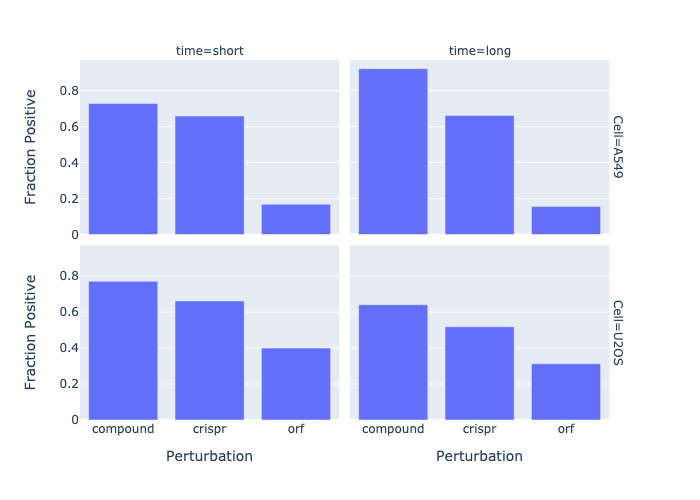

In [7]:
fig = px.bar(
    data_frame=replicability_fp_df,
    x="Modality",
    y="fp",
    facet_row="Cell",
    facet_col="time",
)
fig.update_layout(
    xaxis1=dict(title="Perturbation"),
    xaxis2=dict(title="Perturbation"),
    yaxis1=dict(title="Fraction Positive"),
    yaxis3=dict(title="Fraction Positive"),
)
fig.show("png")
fig.write_image(
    f"figures/1.CellProfiler_replicability_fp.png", width=640, height=480, scale=2
)

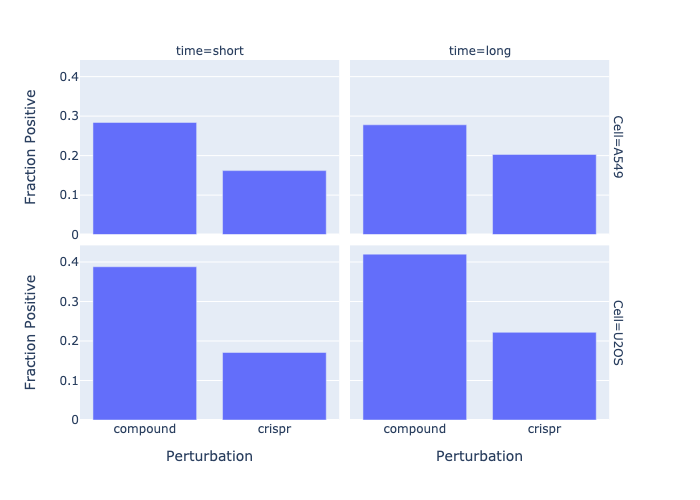

In [8]:
fig = px.bar(
    data_frame=matching_fp_df,
    x="Modality",
    y="fp",
    facet_row="Cell",
    facet_col="time",
)
fig.update_layout(
    xaxis1=dict(title="Perturbation"),
    xaxis2=dict(title="Perturbation"),
    yaxis1=dict(title="Fraction Positive"),
    yaxis3=dict(title="Fraction Positive"),
)
fig.show("png")
fig.write_image(
    f"figures/1.CellProfiler_matching_fp.png", width=640, height=480, scale=2
)

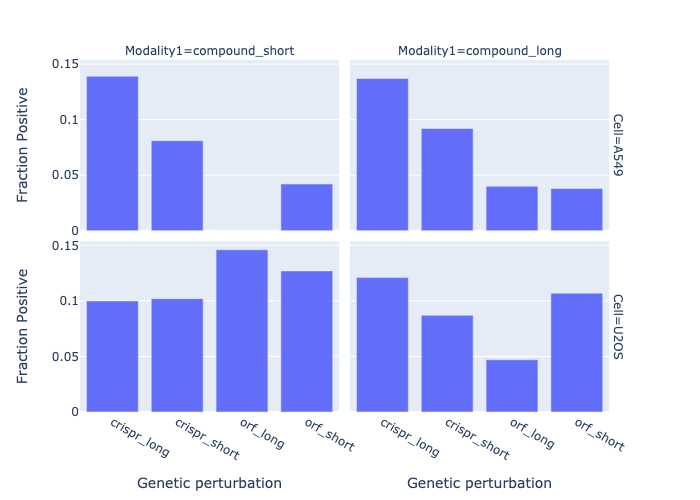

In [9]:
fig = px.bar(
    gene_compound_matching_fp_df,
    x="Modality2",
    y="fp",
    facet_col="Modality1",
    facet_row="Cell",
)
fig.update_layout(
    xaxis1=dict(title="Genetic perturbation"),
    xaxis2=dict(title="Genetic perturbation"),
    yaxis1=dict(title="Fraction Positive"),
    yaxis3=dict(title="Fraction Positive"),
)
fig.show("png")
fig.write_image(
    f"figures/1.CellProfiler_gene_compound_matching_fp.png",
    width=640,
    height=480,
    scale=2,
)

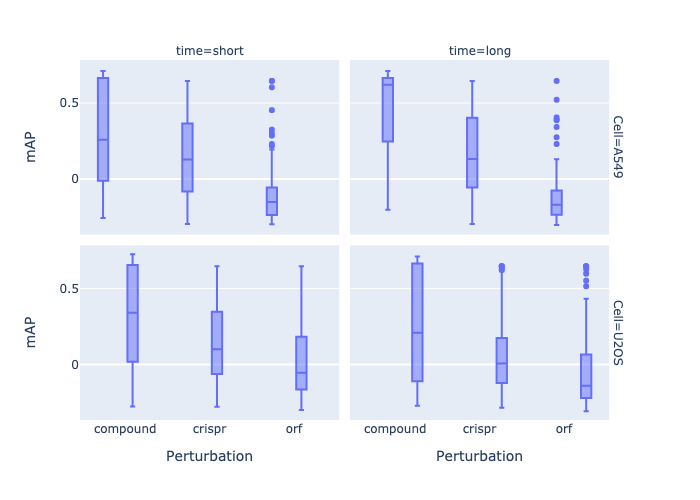

In [10]:
fig = px.box(
    data_frame=replicability_map_df,
    x="Modality",
    y="mAP",
    facet_row="Cell",
    facet_col="time",
)
fig.update_layout(
    xaxis1=dict(title="Perturbation"),
    xaxis2=dict(title="Perturbation"),
    yaxis1=dict(title="mAP"),
    yaxis3=dict(title="mAP"),
)
fig.show("png")
fig.write_image(
    f"figures/1.CellProfiler_replicability_map.png", width=640, height=480, scale=2
)

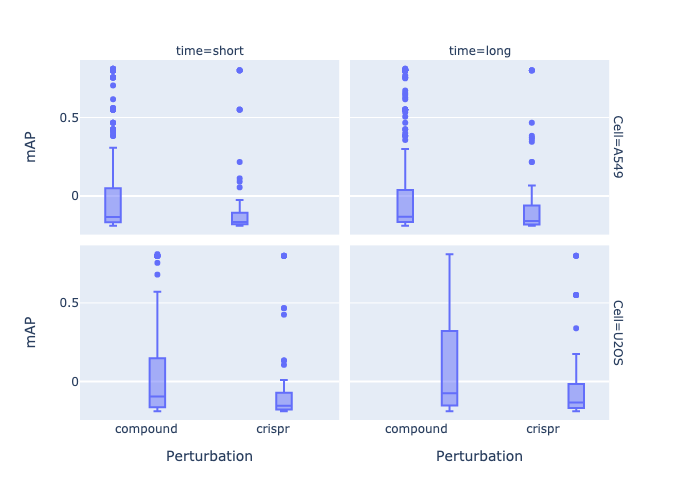

In [11]:
fig = px.box(
    data_frame=matching_map_df,
    x="Modality",
    y="mAP",
    facet_row="Cell",
    facet_col="time",
)
fig.update_layout(
    xaxis1=dict(title="Perturbation"),
    xaxis2=dict(title="Perturbation"),
    yaxis1=dict(title="mAP"),
    yaxis3=dict(title="mAP"),
)
fig.show("png")
fig.write_image(
    f"figures/1.CellProfiler_matching_map.png", width=640, height=480, scale=2
)

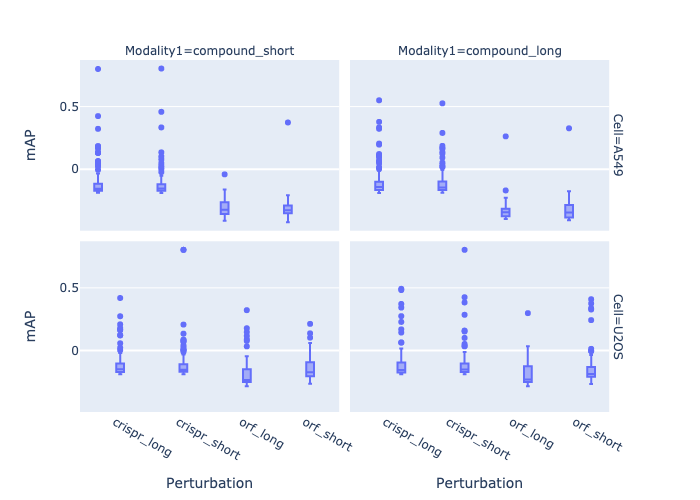

In [12]:
fig = px.box(
    data_frame=gene_compound_matching_map_df,
    x="Modality2",
    y="mAP",
    facet_col="Modality1",
    facet_row="Cell",
)
fig.update_layout(
    xaxis1=dict(title="Perturbation"),
    xaxis2=dict(title="Perturbation"),
    yaxis1=dict(title="mAP"),
    yaxis3=dict(title="mAP"),
)
fig.show("png")
fig.write_image(
    f"figures/1.CellProfiler_gene_compound_matching_map.png",
    width=640,
    height=480,
    scale=2,
)

Tables of mAP and fp values are written to file.

In [13]:
replicability_fp_df[["Modality", "Cell", "time", "fp"]].to_csv(
    "output/cellprofiler_replicability_fp.csv", index=False
)
replicability_map_df[
    ["Modality", "Cell", "time", "Metadata_broad_sample", "mAP"]
].to_csv("output/cellprofiler_replicability_map.csv", index=False)
matching_fp_df[["Modality", "Cell", "time", "fp"]].to_csv(
    "output/cellprofiler_matching_fp.csv", index=False
)
matching_map_df[["Modality", "Cell", "time", "mAP"]].to_csv(
    "output/cellprofiler_matching_map.csv", index=False
)
gene_compound_matching_fp_df[["Modality1", "Modality2", "Cell", "fp"]].to_csv(
    "output/cellprofiler_gene_compound_matching_fp.csv", index=False
)
gene_compound_matching_map_df[["Modality1", "Modality2", "Cell", "mAP"]].to_csv(
    "output/cellprofiler_gene_compound_matching_map.csv", index=False
)